# Описание задачи

В этом сезоне профиля «Искусственный интеллект» НТО вам предстоит поработать с новым форматом данных – видео. В рамках задачи 2 этапа вам нужно разработать алгоритм, который распределит короткие видео (<1 минуты) на 9 заданных классов: 

- animal – в видео присутствует одно или несколько животных;
- car – в видео присутствуют автомобили;
- cloud – в видео показано небо в облаках (тучах);
- dance – в видео есть танцующий человек (люди);
- fire – в видео присутствует пламя (огонь, пламя свечи и т.д.);
- flower – в видео присутствуют цветы;
- food – в видео готовят еду, либо просто присутствует еда;
- sunset – в видео показан закат или рассвет;
- water – в видео показана поверхность воды.

Задачи классификации, к которым относится и эта, являются важнейшим классом задач обучения с учителем (supervised learning). При этом стандартные подходы к классификации изображений могут быть расширены и на видео, которые, по сути, представляют из себя последовательность изображений, распределённых во времени. Задача классификации коротких видеофрагментов имеет широкое практическое применение, а успешные модели могут быть использованы, например, для фильтрации видео-контента или тематической классификации видео, а также в задаче поиска (information retrieval).

**Формат решений**

В проверяющую систему необходимо отправить код алгоритма, запакованный в ZIP-архив. Решения запускаются в изолированном окружении при помощи Docker. Время и ресурсы во время тестирования ограничены: 

- 5Gb на архив с решением
- 25 минут на работу решения

Так как решение не имеет доступ к интернету, все дополнительные данные, например, веса обученной модели, должны быть подгружены в контейнер. В качестве примеры организаторы предоставляют контейнер для запуска бейзлайн-решения.

**Доступные ресурсы:**
- 8 ядер CPU
- 48Gb RAM
- Видеокарта NVidia Tesla V100

**Метрика**

Для оценки решений участников будет использована метрика accuracy, которая показывает долю верно классифицированных объектов выборки.

Метрика accuracy является стандартной метрикой для задач классификации. Она характеризует долю точных совпадений среди пар предсказанных и истинных ответов, то есть отражает отношение числа совпавших ответов (когда модель участника предсказала такой же ответ, как истинный) к общему числу ответов (независимо от того, в определении какого именно класса модель допустила ошибку). Эта метрика изменяется от 0 до 1, где 0 – наихудшее значение, 1 – наилучшее.

**Baseline**

Вам доступно базовое решение от разработчиков задачи с использованием фреймворка PyTorch. 

Предполагаемый пайплайн работы модели включает в себя следующие этапы:
1. вычисление для input видео соответствующих им векторных представлений (эмбеддинги);
2. предсказание для каждого из получившихся эмбеддингов метки (лэйбла) одного из классов.

https://drive.google.com/drive/folders/190bq-AUJTwMza179pVlH_FMDdA5sOjup?usp=share_link

https://ods.ai/competitions/nto22-23/data

In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 58 kB/s 


In [2]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 29.8 MB/s 
     |████████████████████████████████| 182 kB 70.8 MB/s 


In [42]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 30.5 MB/s 
     |████████████████████████████████| 182 kB 74.1 MB/s 
     |████████████████████████████████| 168 kB 81.2 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 168 kB 83.0 MB/s 
     |████████████████████████████████| 166 kB 87.8 MB/s 
     |████████████████████████████████| 166 kB 88.0 MB/s 
     |████████████████████████████████| 162 kB 86.4 MB/s 
     |████████████████████████████████| 162 kB 81.3 MB/s 
     |████████████████████████████████| 158 kB 86.6 MB/s 
     |████████████████████████████████| 157 kB 85.7 MB/s 
     |████████████████████████████████| 157 kB 82.2 MB/s 
     |████████████████████████████████| 157 kB 87.6 MB/s 
     |████████████████████████████████| 157 kB 87.8 MB/s 
     |████████████████████████████████| 157 kB 85.3 MB/s 
     |███████████████████████████

In [43]:
import os
import sys
import re
import gc
import platform
import random
import argparse

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import einops

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
import glob
import cv2

from numpy import array
from numpy import argmax

from tqdm import tqdm
from tqdm.contrib import tzip

import warnings

import wandb

warnings.simplefilter('ignore')

In [5]:
# Монтирует google disk в colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
url = os.chdir(r"/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/нто БД/БД второй тур (командный)")
os.getcwd()

'/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/нто БД/БД второй тур (командный)'

In [ ]:
os.listdir('train_video/')

In [7]:
def read_video(path, img_size, transform=None, frames_num=6):
    frames = []
    cap = cv2.VideoCapture(path)

    fps = int(cap.get(cv2.CAP_PROP_FPS)) # число кадров в секунду
    # print(fps)

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # количество кадров
    # print(length)

    # мы берем не все кадры из видео, потому что их может быть много
    # а только frames_num (ну тут 6 написано)
    #  как мы берем? первые 6? последние 6? в середине 6?
    # нет берем кадры через определенный шаг, он вычисляется как N:
    N = length // (frames_num)

    current_frame = 1

    # в цикле по очереди считываем кадрый из видео
    for i in range(length):
        ret, frame = cap.read(current_frame)

        if ret and i == current_frame and len(frames) < frames_num:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # все кадры в BGR (поэтому перводим в RGB)
            frame = cv2.resize(frame, img_size)

            frames.append(frame)
            current_frame += N

    cap.release()
    
    # frames - это список состоящий из 6 трехмерных матрицы
    # 6 кадров
    # каждый кадр - это трех мерная матрица (потому что RGB)
    return frames

In [ ]:
video1 = read_video('train_video/Oregon Portland south park art museum_preview.mp4', (224, 224))

In [ ]:
video1[0].shape

(224, 224, 3)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
video1[0]

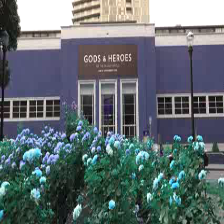

In [ ]:
cv2_imshow(video1[4])

**Про класс DataSet:**

https://habr.com/ru/company/piter/blog/354912/

In [8]:
# Класс для создания датасета
# он создается наследую базовый класс pytorch - Dataset 
class RSNADataset(Dataset):
    # def __init__ - конструктор класс
    def __init__(self, df,  conf, is_test=False):
        # conf - это переменная в которой просто разные настройки лежат
        # она ниже определена
        self.conf = conf
        # df - это train.csv (где лежит название видео и его класс)
        self.df = df
        # transform - преобразование матриц кадров в тензоры (так как pytorch работает только с тензорами)
        # тензор по сути тоже самое что вектор (ну почти:) )
        self.transform = A.Compose([
            ToTensorV2(p=1.0),
        ],p=1.)
        
        self.is_test = is_test
        self.samples = []
        self.cls = {'water':0,'car':1,'cloud':2,'food':3,'flower':4,'dance':5,'animal':6,
                    'sunset':7,'fire':8,'cloud, sunset':2,'water, flower':0,'cloud, water':2}
        
        for path, label in tzip(df.path, df.labels):
            frames = read_video(self.conf['video_path'] + f'/{path}', self.conf['IMG_SIZE'], self.conf['MAX_FRAMES'])
            self.samples +=[{'label': self.cls[str(label)],'frames': frames}]
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        frames = sample['frames']

        frames_tr = torch.from_numpy(np.stack(frames, axis=2)).permute(2, 3, 0, 1)
            
        if self.is_test:
            return frames_tr
        else:
            label = torch.tensor(sample['label']).long()
            return frames_tr, label

По сути в samples лежит словарь для каждого видео, в словаре два ключа:
1. label - класс к каждому кадру из видео
2. frames - кадры из этого видео

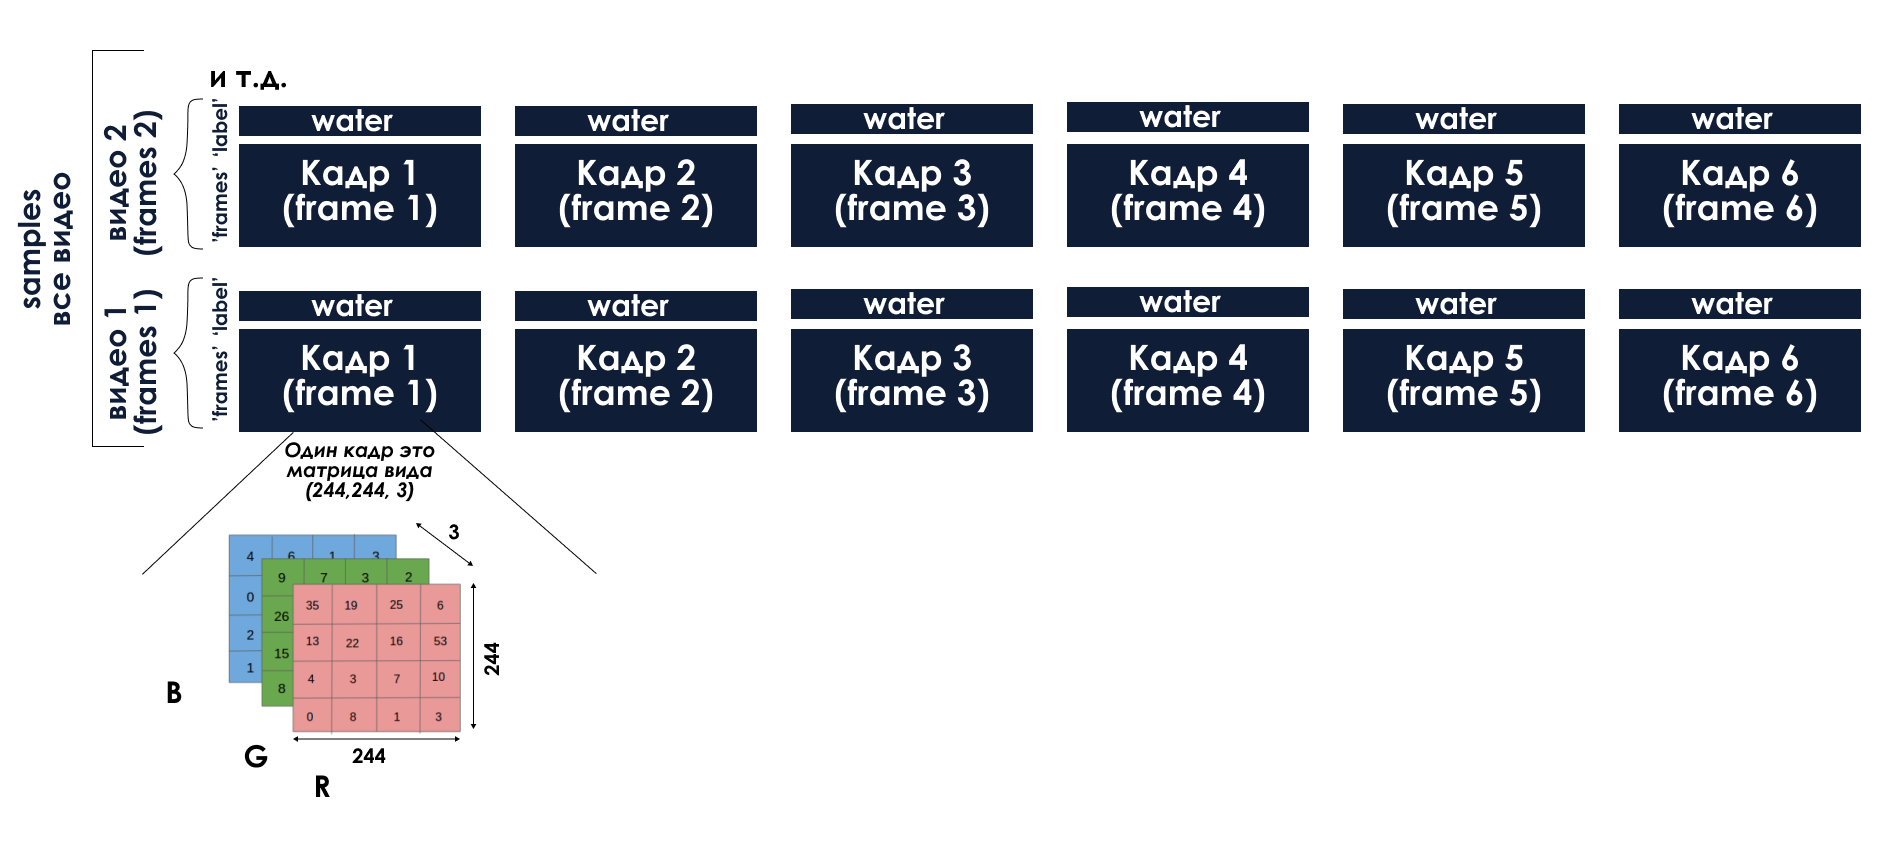

In [10]:
df_train = pd.read_csv('/content/gdrive/MyDrive/Я-профи подготовка по машинному обучению/нто БД/БД второй тур (командный)/train.csv', index_col=0)

df_train.head()

,path,labels
578,France Argentiere church and cross with Alps_p...,cloud
229,Georgia Okefenokee reflections in scummy water...,water
544,170728_Berlin_A_012_preview.mp4,sunset
369,170209D_039_Diving_1080p_preview.mp4,water
442,motionplaces flower-Oct2018_preview.mp4,flower


In [11]:
%%time
conf = dict(
        MAX_FRAMES=12,
        EPOCHS=5,
        LR=2e-4,
        IMG_SIZE=(224, 224),
        FEATURE_EXTRACTOR='resnext50_32x4d',
        DR_RATE=0.35,
        NUM_CLASSES=12,
        RNN_HIDDEN_SIZE=256,
        RNN_LAYERS=1,
        TEST_BS=4,
        NUM_WORKERS=4,
        # MODEL_PATH=args.weight_path,
        video_path='train_video/'
    )

train_data = RSNADataset(df_train, conf)

train_loader = DataLoader(
        train_data,
        batch_size=4,
        shuffle=False
    )

  0%|          | 0/522 [00:00<?, ?it/s]

CPU times: user 2min 23s, sys: 9.93 s, total: 2min 33s
Wall time: 11min 43s


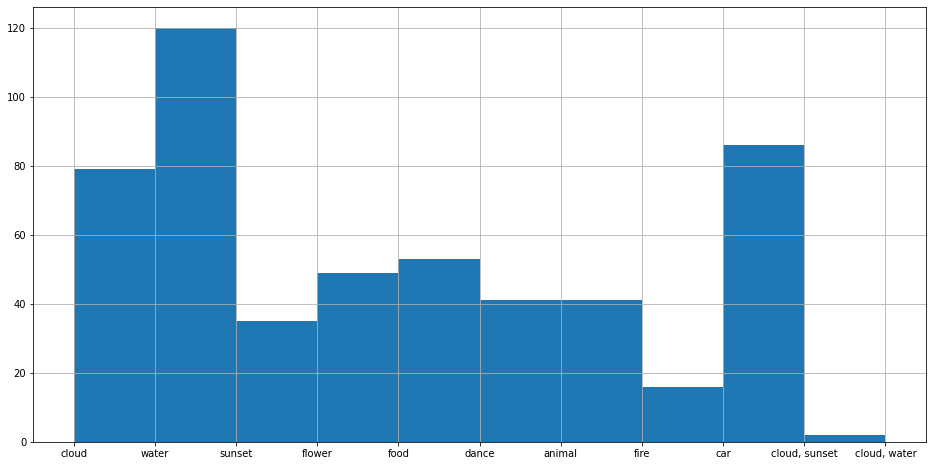

In [12]:
df_train.labels.hist(figsize=(16,8))

In [13]:
df_train['labels'].value_counts()

water            120
car               86
cloud             79
food              53
flower            49
dance             41
animal            41
sunset            35
fire              16
cloud, sunset      1
cloud, water       1
Name: labels, dtype: int64

In [26]:
print(f'Sample len (это эквивалентно количество видео): {len(train_data.samples)}') # всего в датасете 522 видео
print(f'Что лежит в одном видео: {len(train_data.samples[0])}') # в каждом видео лежат два ключа
print(f'Какие ключи: {train_data.samples[0].keys()}')# в каждом видео лежат два ключа
print(f'Что лежит в ключе labels: {train_data.samples[0]["label"]}')# ключ label
print(f'размерность данных по ключу frames: {len(train_data.samples[0]["frames"])}')# лежит 6, так как кадров из видео 6
print(f'Размерность одного кадра, frame: {train_data.samples[0]["frames"][0].shape}') # что лежит в одном кадре, его размерность

Sample len (это эквивалентно количество видео): 522
Что лежит в одном видео: 2
Какие ключи: dict_keys(['label', 'frames'])
Что лежит в ключе labels: 2
размерность данных по ключу frames: 6
Размерность одного кадра, frame: (224, 224, 3)


In [27]:
## Model Class
# 

class ResNextModel(nn.Module):
    def __init__(self, conf):
        super(ResNextModel, self).__init__()
        self.conf = conf
        self.backbone = timm.create_model(self.conf['FEATURE_EXTRACTOR'])

    def forward(self, x):
        return self.backbone(x)


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class RSNAModel(nn.Module):
    def __init__(self, conf, pretrained=True):
        super(RSNAModel, self).__init__()
        self.conf = conf
        self.backbone = ResNextModel(self.conf)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.num_features = self.backbone.backbone.fc.in_features

        self.backbone.backbone.fc = Identity()
        self.dropout = nn.Dropout(self.conf['DR_RATE'])
        self.rnn = nn.LSTM(self.num_features, self.conf['RNN_HIDDEN_SIZE'], self.conf['RNN_LAYERS'], dropout=0.1,
                           batch_first=True, bidirectional=True)  # bidirectional=True
        self.fc1 = nn.Linear(self.conf['RNN_HIDDEN_SIZE'] * 2, self.conf['NUM_CLASSES'])

    def forward(self, x):
        b, f, c, h, w = x.shape
        # print(x.reshape(b * f, c, h, w).shape)
        x = self.backbone(x.reshape(b * f, c, h, w))
        # print(x.shape)
        x = x.reshape(b, f, self.num_features)
        # print(x.shape)
        x, _ = self.rnn(x)
        # print(x.shape)
        x = self.dropout(x[:, -1])  #
        # print(x.shape, self.num_features)
        x = self.fc1(x)
        return x

In [49]:
# Функции обучения нейронной сети
def train_one_epoch(model, train_loader, optimizer, loss_fn, epoch, device, log_wandb=True, verbose=False):
    """
    Trains model for one epoch
    """
    model.train()
    running_loss = 0
    prog_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch, (frames, targets) in prog_bar:
        optimizer.zero_grad()
        
        frames = frames.to(device, torch.float)
        targets = targets.to(device)
        
        # Re arrange the frames in the format our model wants to recieve
        preds = model(frames)
        loss = loss_fn(preds, targets)
        
        loss.backward()
        optimizer.step()
        
        loss_item = loss.item()
        running_loss += loss_item
        
        prog_bar.set_description(f"loss: {loss_item:.4f}")
        
        # if log_wandb == True:
        #     wandb_log(
        #         batch_train_loss=loss_item
        #     )
        
        if verbose == True and batch % 20 == 0:
            print(f"Batch: {batch}, Loss: {loss_item}")
    
    avg_loss = running_loss / len(train_loader)
    
    return avg_loss

# @torch.no_grad()
# def valid_one_epoch(model, valid_loader, loss_fn, epoch, device, log_wandb=True, verbose=False):
#     """
#     Validates the model for one epoch
#     """
#     model.eval()
#     running_loss = 0
#     prog_bar = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader))
#     for batch, (frames, targets) in prog_bar:
#         frames = frames.to(device, torch.float)
#         targets = targets.to(device)
        
#         # Re arrange the frames in the format our model wants to recieve
#         preds = model(frames)
#         loss = loss_fn(preds, targets)
        
#         loss_item = loss.item()
#         running_loss += loss_item
        
#         prog_bar.set_description(f"val_loss: {loss_item:.4f}")
        
#         if log_wandb == True:
#             wandb_log(
#                 batch_val_loss=loss_item
#             )
        
#         if verbose == True and batch % 10 == 0:
#             print(f"Batch: {batch}, Loss: {loss_item}")
    
#     avg_val_loss = running_loss / len(valid_loader)
    
#     return avg_val_loss

https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model

In [36]:
def wandb_log(**kwargs):
    """
    Logs a key-value pair to W&B
    """
    for k, v in kwargs.items():
        wandb.log({k: v})

In [50]:
# Функция main, которая собирает все вместе
# она принимает разные конфигурации для выполнения всех программ
# лоадер данных - df_loader
# df - это датафрейм (где путь, класс)
# output_path - путь куда сохранить ответы
# device - GPU/CPU - на чем делать вычисления
def main(conf, df_loader, df, output_path, device):

    # создаем модель
    model = RSNAModel(conf)
    # загружаем веса модели
    model.load_state_dict(torch.load(conf['MODEL_PATH']))
    # передаем модели на чем делать вычисления GPU/CPU
    model = model.to(device)

    # Тут начинается обучение модели
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=conf['LR'])

    train_loss_fn = nn.CrossEntropyLoss()

    print(f"\nUsing Backbone: {conf['FEATURE_EXTRACTOR']}")

    current_loss = 1000
    for epoch in range(conf['EPOCHS']):
        print(f"\n{'--'*8} EPOCH: {epoch+1} {'--'*8}\n")
            
        train_loss = train_one_epoch(model, train_loader, optimizer, train_loss_fn, epoch=epoch, device=device, log_wandb=log_wandb)
            
        # if log_wandb == True:
        #     wandb_log(
        #             train_loss=train_loss
        #     )
            
        if train_loss < current_loss:
            current_loss = train_loss
            torch.save(model.state_dict(), f"model_myself_{conf['FEATURE_EXTRACTOR']}.pt")

    # тут происходит предсказание ответа
    gt = []
    pred = [] # массив куда будем сохранять ответы
    model.eval()

    # prog_bar - это просто чтобы красиво выводился процесс вычисления
    # в виде бегущей крассивой штукой и показом процента выполнения
    prog_bar = tqdm(enumerate(df_loader), total=len(df_loader))
    for batch, (frames, targets) in prog_bar:
        frames = frames.to('cuda').float()
        gt +=  list(targets.numpy())

        with torch.no_grad():
            pred += list(model(frames).argmax(dim=-1).to('cpu').flatten().numpy())

    # сохраняем ответы в датафрейм с путями в новую колонку labels_pred
    df['labels_pred'] = pred

    # сохраняем ответы в файл csv
    os.makedirs(output_path, exist_ok=True)
    df['labels_pred'].to_csv(output_path + 'predictions.csv')

In [51]:
%%time

# ВСЕ ЗАПУСКАЕМ

conf = dict(
    MAX_FRAMES=12,
    EPOCHS=5,
    LR=2e-4,
    IMG_SIZE=(224, 224),
    FEATURE_EXTRACTOR='resnext50_32x4d',
    DR_RATE=0.35,
    NUM_CLASSES=12,
    RNN_HIDDEN_SIZE=256,
    RNN_LAYERS=1,
    TEST_BS=4,
    NUM_WORKERS=4,
    MODEL_PATH='submit/weights/model_resnext50_32x4d.pt',
    video_path='train_video/'
)

if torch.cuda.is_available():
    print("Using GPU: {}\n".format(torch.cuda.get_device_name()))
    device = torch.device('cuda')
else:
    print("\nGPU not found. Using CPU: {}\n".format(platform.processor()))
    device = torch.device('cpu')

main(conf,  train_loader, df_train, 'output/', device)

Using GPU: Tesla T4


Using Backbone: resnext50_32x4d

---------------- EPOCH: 1 ----------------



loss: 0.8756: 100%|██████████| 131/131 [00:15<00:00,  8.59it/s]



---------------- EPOCH: 2 ----------------



loss: 1.1040: 100%|██████████| 131/131 [00:15<00:00,  8.41it/s]



---------------- EPOCH: 3 ----------------



loss: 0.6159: 100%|██████████| 131/131 [00:15<00:00,  8.45it/s]



---------------- EPOCH: 4 ----------------



loss: 0.4188: 100%|██████████| 131/131 [00:15<00:00,  8.29it/s]



---------------- EPOCH: 5 ----------------



100%|██████████| 131/131 [00:14<00:00,  9.15it/s]

CPU times: user 1min 31s, sys: 1.31 s, total: 1min 32s
Wall time: 1min 35s


In [55]:
classes = {'water':0,'car':1,'cloud':2,'food':3,'flower':4,'dance':5,'animal':6,
           'sunset':7,'fire':8,'cloud, sunset':2,'water, flower':0,'cloud, water':2}

df_train['labels_num'] = df_train['labels'].map(classes)

df_train

,path,labels,labels_pred,labels_num
578,France Argentiere church and cross with Alps_p...,cloud,2,2
229,Georgia Okefenokee reflections in scummy water...,water,0,0
544,170728_Berlin_A_012_preview.mp4,sunset,7,7
369,170209D_039_Diving_1080p_preview.mp4,water,0,0
442,motionplaces flower-Oct2018_preview.mp4,flower,4,4
...,...,...,...,...
125,190212_03_MarrakechKoutoubia_HD_07_preview.mp4,water,0,0
401,170609_B_DelhiJamaMasjid_004_preview.mp4,food,3,3
464,034660478-berlin-reichstag-backlit-drama_previ...,cloud,2,2
182,California smoke in evening sky_preview.mp4,cloud,2,2


In [58]:
from sklearn.metrics import accuracy_score, f1_score
print(accuracy_score(df_train['labels_num'].values, df_train['labels_pred'].values))
print(f1_score(df_train['labels_num'].values, df_train['labels_pred'].values, average='weighted'))

0.89272030651341
0.8931084235860929
